# Summary


Set `CORE_OR_INTERFACE` to `0` to load data for CORE mutatations (both standalone and database).

Set `CORE_OR_INTERFACE` to `1` to load data for INTERFACE mutations (both standalone and database).

-----

# Imports

In [2]:
%run imports.ipynb

2016-09-19 22:24:28.458798


In [3]:
%run db.ipynb

MySQL database already running...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-09-19 22:24:28.611740


In [4]:
NOTEBOOK_NAME = 'load_data'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [5]:
CORE_OR_INTERFACE = 1

In [6]:
if CORE_OR_INTERFACE == 0:
    COI_SUFFIX = '_CORE'

    # Standalone gets '_core' suffix
    DATASETS_STANDALONE = [
        'protherm_star', 'protherm',
        # Interface mutations
        'kortemme_baker', 'skempi',
        'ab_bind', 'benedix_et_al', 'hiv_escape_mutations',
    ]

    DATASETS_DATABASE_LOCAL = [
        'protherm_star', 'protherm', 'taipale',
        # Interface mutations
        'skempi', 'taipale_ppi', 'taipale_gpca',
    ]

    DATASETS_DATABASE_REMOTE = [
        'humsavar', 'clinvar', 'cosmic', 'cagi4_sumo_ligase',

    ]
    
    DATABASE_MAP = {
        x: ('protein_interaction_energy', 'elaspic_training_interface')
        for x in ['skempi', 'taipale_ppi', 'taipale_gpca']
    }

In [7]:
if CORE_OR_INTERFACE == 1:
    COI_SUFFIX = '_INTERFACE'

    # Standalone gets '_interface' suffix
    DATASETS_STANDALONE = [
        'kortemme_baker', 'skempi',
        'ab_bind', 'benedix_et_al', 'hiv_escape_mutations',
    ]

    DATASETS_DATABASE_LOCAL = [
        'skempi', 'taipale_ppi', 'taipale_gpca',
    ]

    DATASETS_DATABASE_REMOTE = [
        'taipale',
        'humsavar', 'clinvar', 'cosmic', 'cagi4_sumo_ligase',
    ]
    
    DATABASE_MAP = {}

# DATA

## Standalone

In [35]:
DATA_STANDALONE = {}

In [36]:
def load_data_standalone(dataset):
    df = pd.read_sql_table(dataset, db.engine, schema='elaspic_standalone')
    df['dataset'] = dataset
    assert ((df['alignment_identity'] > 0.01) & (df['alignment_identity'] < 1.01)).all()
    assert ((df['alignment_coverage'] > 0.01) & (df['alignment_coverage'] < 1.01)).all()
    df = elaspic.elaspic_predictor.format_mutation_features(df)
    df = elaspic.elaspic_predictor.convert_features_to_differences(df)
    assert 'dg_change' in df.columns, df[[c for c in df.columns if c.startswith('dg')]].dtypes
    return df

In [37]:
for dataset in DATASETS_STANDALONE:
    print(dataset)
    df = load_data_standalone(dataset + COI_SUFFIX.lower())
    df = kmtools.df_tools.remove_duplicate_columns(df, keep_first=False)
    DATA_STANDALONE[dataset] = df

protherm_star
protherm
kortemme_baker
skempi
ab_bind
benedix_et_al
hiv_escape_mutations


In [38]:
with open(op.join(NOTEBOOK_NAME, 'DATA_STANDALONE{}.pkl'.format(COI_SUFFIX.upper())), 'wb') as ofh:
    pickle.dump(DATA_STANDALONE, ofh, pickle.HIGHEST_PROTOCOL)

## Database

In [11]:
DATA_DATABASE = {}

### Construct SQL query

In [12]:
# CORE SQL query template
sql_query_template = """\
SELECT *
FROM (
    SELECT
    muts.uniprot_mutation mutation,
    muts.*
    FROM {mutation_schema}.{mutation_table_name} muts
) t1
JOIN {elaspic_schema}.uniprot_sequence us USING (uniprot_id)
JOIN {elaspic_schema}.uniprot_domain_mutation mut USING (uniprot_id, mutation)
JOIN {elaspic_schema}.uniprot_domain_model m USING (uniprot_domain_id)
JOIN {elaspic_schema}.uniprot_domain_template t USING (uniprot_domain_id)
JOIN {elaspic_schema}.uniprot_domain d USING (uniprot_domain_id)
-- {partner_uniprot_id}
"""

In [13]:
# INTERFACE SQL query template
if CORE_OR_INTERFACE == 1:
    sql_query_template = """\
SELECT *
FROM (
    SELECT
    muts.uniprot_mutation mutation,
    {partner_uniprot_id}
    muts.*
    FROM {mutation_schema}.{mutation_table_name} muts
) t1
JOIN {elaspic_schema}.uniprot_sequence us USING (uniprot_id)
JOIN {elaspic_schema}.uniprot_domain_pair_mutation mut USING (uniprot_id, mutation)
JOIN {elaspic_schema}.uniprot_domain_pair_model m USING (uniprot_domain_pair_id)
JOIN {elaspic_schema}.uniprot_domain_pair_template t USING (uniprot_domain_pair_id)
JOIN {elaspic_schema}.uniprot_domain_pair d USING (uniprot_domain_pair_id)

WHERE 
    ((partner_uniprot_id is NULL) OR
     ((uniprot_id = d.uniprot_id_1 AND partner_uniprot_id = d.uniprot_id_2) OR
      (uniprot_id = d.uniprot_id_2 AND partner_uniprot_id = d.uniprot_id_1)));
"""

In [14]:
# Functions
def load_dataset(mutation_table_name, mutation_schema, elaspic_schema, engine, partner_uniprot_id=''):
    sql_query = (
        sql_query_template.format(
            mutation_table_name=mutation_table_name,
            mutation_schema=mutation_schema,
            elaspic_schema=elaspic_schema,
            partner_uniprot_id=partner_uniprot_id)
    )

    df = pd.read_sql_query(sql_query, engine)
    df = kmtools.df_tools.remove_duplicate_columns(df, keep_first=False)

    print("{} [{} / {}]: ({})".format(mutation_table_name, mutation_schema, elaspic_schema, df.shape[0]))
    
    # Read sql query
    if 'uniprot_mutation' not in df.columns:
        df['uniprot_mutation'] = df['mutation']
    else:
        assert (df['uniprot_mutation'] == df['mutation']).all()
        df.drop('uniprot_mutation', axis=1)

    
    # === All these rules could be converted to SQL... ===
    # Remove rows with null mutations
    null_mutants_ = (df['uniprot_mutation'].isnull()) | (df['uniprot_mutation'] == '-')
    print("Removing {} null mutants...".format(null_mutants_.sum()))
    df = df[~null_mutants_]

    # Remove SIFTS errors
    sifts_errors_ = df['uniprot_mutation'] == '?'
    print("Removing {} sifts errors...".format(sifts_errors_.sum()))
    df = df[~sifts_errors_]

    # Remove rows with weird mutations
    multi_mutants_ = df['uniprot_mutation'].str.contains(',')
    print("Removing {} multi mutants...".format(multi_mutants_.sum()))
    df = df[~multi_mutants_]

    # Remove wild-type rows
    wild_ = (df['uniprot_mutation'].str.lower() == 'wild')
    print("Removing {} wild mutants...".format(wild_.sum()))
    df = df[~wild_]

    # Remove synonymous mutations
    synonymous_ = df['uniprot_mutation'].str[0] == df['uniprot_mutation'].str[-1]
    print("Removing {} synonymous mutants...".format(synonymous_.sum()))
    df = df[~synonymous_]

    # Remove sequence mismatch mutations
    mutation_matches_sequence_ = (
        df[['uniprot_mutation', 'uniprot_sequence']]
        .apply(lambda x: kmtools.sequence_tools.mutation_matches_sequence(*x), axis=1)
    )
    mutation_matches_sequence_ = mutation_matches_sequence_.fillna(False)
    print("Removing {} mutations not matching sequence...".format((mutation_matches_sequence_ == False).sum()))
    df = df[mutation_matches_sequence_]

    # Convert ELASPIC features to expected format
    shape_before = df.shape[0]
    df = elaspic.elaspic_predictor.format_mutation_features(df)
    df = elaspic.elaspic_predictor.convert_features_to_differences(df)
    shape_after = df.shape[0]
    assert shape_before == shape_after
    
    # DONE!
    print('-' * 80, flush=True)
    return df

### Run SQL query

In [25]:
# params
params = []

if CORE_OR_INTERFACE == 0:
    local_db_schemas = ['protein_folding_energy', 'elaspic_training_core']

if CORE_OR_INTERFACE == 1:
    local_db_schemas = ['protein_interaction_energy', 'elaspic_training_interface']

In [27]:
for dataset in DATASETS_DATABASE_LOCAL:
    params.append((dataset, *DATABASE_MAP.get(dataset, local_db_schemas), db.engine, ))
    
for dataset in DATASETS_DATABASE_REMOTE:
    params.append((dataset, 'mutation_sets', 'elaspic', db_remote.engine, 'NULL partner_uniprot_id,'))

pprint(params)

[('protherm_star',
  'protein_folding_energy',
  'elaspic_training_core',
  Engine(mysql://root@localhost:8309/elaspic_training_set?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock)),
 ('protherm',
  'protein_folding_energy',
  'elaspic_training_core',
  Engine(mysql://root@localhost:8309/elaspic_training_set?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock)),
 ('taipale',
  'protein_folding_energy',
  'elaspic_training_core',
  Engine(mysql://root@localhost:8309/elaspic_training_set?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock)),
 ('skempi',
  'protein_interaction_energy',
  'elaspic_training_interface',
  Engine(mysql://root@localhost:8309/elaspic_training_set?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock)),
 ('taipale_ppi',
  'protein_interaction_energy',
  'elaspic_training_interface',
  Engine(mysql://root@localhost:8309/elaspic_training_set?unix_socket=/tmp/strokach/elaspic_training_set/mysql.sock)),
 ('taipale_gpca',
  'protein_interact

In [28]:
# Get data from database
results = {}
for args in params:
    result = load_dataset(*args)
    results[args[0]] = result

Removed column 'uniprot_id' at position 61.


protherm_star [protein_folding_energy / elaspic_training_core]: (9707)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 0 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 63.


protherm [protein_folding_energy / elaspic_training_core]: (9506)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 0 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 57.


taipale [protein_folding_energy / elaspic_training_core]: (3399)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 0 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'pfam_clan' at position 55.
Removed column 'uniprot_id' at position 65.


skempi [protein_interaction_energy / elaspic_training_interface]: (1630)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 1 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 59.


taipale_ppi [protein_interaction_energy / elaspic_training_interface]: (285)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 0 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 59.


taipale_gpca [protein_interaction_energy / elaspic_training_interface]: (191)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 0 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 58.


humsavar [mutation_sets / elaspic]: (32311)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 27 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 58.


clinvar [mutation_sets / elaspic]: (63642)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 44 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 58.


cosmic [mutation_sets / elaspic]: (358134)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 131 mutations not matching sequence...
--------------------------------------------------------------------------------


Removed column 'uniprot_id' at position 56.


cagi4_sumo_ligase [mutation_sets / elaspic]: (676)
Removing 0 null mutants...
Removing 0 sifts errors...
Removing 0 multi mutants...
Removing 0 wild mutants...
Removing 0 synonymous mutants...
Removing 3 mutations not matching sequence...
--------------------------------------------------------------------------------


In [29]:
# Combine into one dict
DATA_DATABASE.update(results)

## Clean results

In [30]:
# Remove splice variants
for dataset in DATA_DATABASE:
    if 'uniprot_id_1' not in DATA_DATABASE[dataset] or 'uniprot_id_2' not in DATA_DATABASE[dataset]:
        continue
    _before = DATA_DATABASE[dataset].shape[0]
    DATA_DATABASE[dataset] = (
        DATA_DATABASE[dataset][
            (DATA_DATABASE[dataset]['uniprot_id_1'].isnull() | 
             ~DATA_DATABASE[dataset]['uniprot_id_1'].str.contains('-').astype(bool)) &
            (DATA_DATABASE[dataset]['uniprot_id_2'].isnull() | 
             ~DATA_DATABASE[dataset]['uniprot_id_2'].str.contains('-').astype(bool))
        ]
    )
    _after = DATA_DATABASE[dataset].shape[0]
    if _before != _after:
        print("{:20s}: {:10d}\t{:10d}".format(dataset, _before, _after))

In [31]:
# Average alignment_identity / alignment_coverage / alignment_score
for dataset in DATASETS_DATABASE_LOCAL + DATASETS_DATABASE_REMOTE:
    print(dataset)
    
    if 'alignment_identity' not in DATA_DATABASE[dataset].columns:
        DATA_DATABASE[dataset]['alignment_identity'] = (
            np.sqrt(DATA_DATABASE[dataset]['identical_1'] * DATA_DATABASE[dataset]['identical_2'])
        )
    assert ((DATA_DATABASE[dataset]['alignment_identity'] > 0.1) & 
            (DATA_DATABASE[dataset]['alignment_identity'] <= 1)).all()
    
    if 'alignment_coverage' not in DATA_DATABASE[dataset].columns:
        DATA_DATABASE[dataset]['alignment_coverage'] = (
            np.sqrt(DATA_DATABASE[dataset]['coverage_1'] * DATA_DATABASE[dataset]['coverage_2'])
        )
    assert ((DATA_DATABASE[dataset]['alignment_coverage'] > 0.01) & 
            (DATA_DATABASE[dataset]['alignment_coverage'] <= 1)).all()
    
    if 'alignment_score' not in DATA_DATABASE[dataset].columns:
        DATA_DATABASE[dataset]['alignment_score'] = (
            np.sqrt(DATA_DATABASE[dataset]['score_1'] * DATA_DATABASE[dataset]['score_2'])
        )
    assert ((DATA_DATABASE[dataset]['alignment_score'] > 0.001) & 
            (DATA_DATABASE[dataset]['alignment_score'] <= 1)).all()

protherm_star
protherm
taipale
skempi
taipale_ppi
taipale_gpca
humsavar
clinvar
cosmic
cagi4_sumo_ligase


In [32]:
for key, df in DATA_DATABASE.items():
    print("{:25s}: {:6}".format(key, df.shape[0]))

clinvar                  :  63598
protherm                 :   9506
humsavar                 :  32284
protherm_star            :   9707
taipale_gpca             :    191
taipale_ppi              :    285
taipale                  :   3399
cagi4_sumo_ligase        :    673
skempi                   :   1629
cosmic                   : 358003


In [33]:
with open(op.join(NOTEBOOK_NAME, 'DATA_DATABASE{}.pkl'.format(COI_SUFFIX.upper())), 'wb') as ofh:
    pickle.dump(DATA_DATABASE, ofh, pickle.HIGHEST_PROTOCOL)

# DATA_DF

Combine data into a DataFrame.

All $\Delta \Delta G$ datasets go into a single "protherm" dataset.

In [8]:
with open(op.join(NOTEBOOK_NAME, 'DATA_STANDALONE{}.pkl'.format(COI_SUFFIX.upper())), 'rb') as ifh:
    DATA_STANDALONE = pickle.load(ifh)
    
with open(op.join(NOTEBOOK_NAME, 'DATA_DATABASE{}.pkl'.format(COI_SUFFIX.upper())), 'rb') as ifh:
    DATA_DATABASE = pickle.load(ifh)

In [9]:
dataset_map = {
    'protherm': 'protherm++',
    'protherm_star': 'protherm++',
    'kortemme_baker': 'skempi++',
    'skempi': 'skempi++',
}

df_list = []

for dataset, df in DATA_STANDALONE.items():
    df['dataset'] = dataset_map.get(dataset, dataset)
    df = kmtools.df_tools.remove_duplicate_columns(df, keep_first=False)
    df_list.append(df)

for dataset, df in DATA_DATABASE.items():
    df['dataset'] = dataset_map.get(dataset, dataset)
    df = kmtools.df_tools.remove_duplicate_columns(df, keep_first=False)
    assert df['uniprot_id'].notnull().all()
    df_list.append(df)

In [10]:
DATA_DF = pd.concat(df_list, ignore_index=True)

In [11]:
_before = DATA_DF.shape[0]
_after = sum(df.shape[0] for df in itertools.chain(DATA_STANDALONE.values(), DATA_DATABASE.values()))
assert _before == _after       

In [12]:
for c in ['ddg_exp', 'del_score_exp', 'del_class_exp']:
    DATA_DF[c] = DATA_DF[c].astype(float)

In [13]:
assert DATA_DF[(DATA_DF['alignment_identity'] > 0.1) & (DATA_DF['alignment_identity'] <= 1.0)].shape[0]

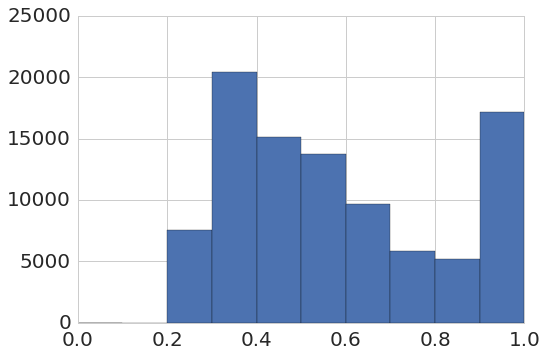

In [14]:
DATA_DF['alignment_identity'].hist(range=(0, 1))

In [15]:
assert (DATA_DF['alignment_identity'] > 0.02).all()

In [16]:
DATA_DF.shape

(94728, 165)

In [17]:
# Set 'max_seq_identity' where it is missing
DATA_DF.loc[DATA_DF['max_seq_identity'].isnull(), 'max_seq_identity'] = (
    DATA_DF[DATA_DF['max_seq_identity'].isnull()]
    ['alignment_identity']
    .apply(local.get_max_seq_identity)
)

In [18]:
display(DATA_DF.head())
print(DATA_DF.shape)

,_index,alignment_coverage,alignment_filename_1,alignment_filename_2,alignment_identity,alignment_score,analyse_complex_energy_mut,analyse_complex_energy_wt,backbone_clash_change,backbone_clash_wt,backbone_hbond_change,backbone_hbond_wt,cath_id_1,cath_id_2,chain_1,chain_2,chain_modeller,cis_bond_change,cis_bond_wt,conserved_1,conserved_2,conserved_if_1,conserved_if_2,contact_distance_change,contact_distance_wt,coverage_1,coverage_2,coverage_if_1,coverage_if_2,dataset,db,ddg,ddg_exp,del_class_exp,del_score_exp,dg_change,dg_wt,disulfide_change,disulfide_wt,domain_contact_id,domain_contact_ids,electrostatic_kon_change,electrostatic_kon_wt,electrostatics_change,electrostatics_wt,energy_ionisation_change,energy_ionisation_wt,entropy_complex_change,entropy_complex_wt,entropy_mainchain_change,entropy_mainchain_wt,entropy_sidechain_change,entropy_sidechain_wt,gene_name,helix_dipole_change,helix_dipole_wt,id,identical_1,identical_2,identical_if_1,identical_if_2,idx,idxs,interacting_aa_1,interacting_aa_2,interface_area_hydrophilic,interface_area_hydrophobic,interface_area_total,interface_dg,intraclashes_energy_1_change,intraclashes_energy_1_wt,intraclashes_energy_2_change,intraclashes_energy_2_wt,m_date_modified,matrix_score,max_seq_identity,mloop_entropy_change,mloop_entropy_wt,model_domain_def_1,model_domain_def_2,model_errors,model_file_mut,model_file_wt,model_filename,model_filename_mut,model_filename_wt,mut_date_modified,mutation,mutation_errors,mutation_modeller,norm_dope,number_of_residues,organism_name,partial_covalent_bonds_change,partial_covalent_bonds_wt,partner_pdb_chain,partner_uniprot_id,path_to_data,pcv_hbond_change,pcv_hbond_self_change,pcv_hbond_self_wt,pcv_hbond_wt,pcv_salt_equal_change,pcv_salt_equal_self_change,pcv_salt_equal_self_wt,pcv_salt_equal_wt,pcv_salt_opposite_change,pcv_salt_opposite_self_change,pcv_salt_opposite_self_wt,pcv_salt_opposite_wt,pcv_vdw_change,pcv_vdw_self_change,pcv_vdw_self_wt,pcv_vdw_wt,pdb_chain,pdb_id,pdb_mutation,pfam_clan,pfam_id,protein_existence,protein_name,provean_score,rigids,score_1,score_2,score_if_1,score_if_2,score_if_total,score_overall,score_total,secondary_structure_change,secondary_structure_wt,sequence_version,sidechain_hbond_change,sidechain_hbond_wt,sloop_entropy_change,sloop_entropy_wt,solvation_hydrophobic_change,solvation_hydrophobic_wt,solvation_polar_change,solvation_polar_wt,solvent_accessibility_change,solvent_accessibility_wt,stability_energy_mut,stability_energy_wt,t_date_modified,template_errors,torsional_clash_change,torsional_clash_wt,uniprot_domain_id_1,uniprot_domain_id_2,uniprot_domain_pair_id,uniprot_domain_pair_id_old,uniprot_id,uniprot_id_1,uniprot_id_2,uniprot_mutation,uniprot_name,uniprot_sequence,van_der_waals_change,van_der_waals_clashes_change,van_der_waals_clashes_wt,van_der_waals_wt,water_bridge_change,water_bridge_wt
0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.41394,2.28539,0.39852,-2.96249,NaN,NaN,NaN,NaN,C,0.0,0.000000,NaN,NaN,NaN,NaN,0.669686,2.316060,NaN,NaN,NaN,NaN,ab_bind,NaN,2.184765,1.300,NaN,NaN,-1.07761,-3.04699,0.0,0.000000e+00,NaN,NaN,0.076265,-0.345444,1.037007,-1.672890,0.0,5.551120e-17,0.0,2.384,0.29724,1.94618,-0.27158,3.74864,NaN,0.000000,-0.029492,NaN,NaN,NaN,NaN,NaN,2.0,"[1, 2]",NaN,NaN,893.155,163.970,1057.125,NaN,-0.6693,35.0678,-0.0071,70.8110,NaT,-2.0,100.0,0.0,0.0,NaN,NaN,NaN,/home/kimlab1/database_data/biodb/recipes/elas...,/home/kimlab1/database_data/biodb/recipes/elas...,NaN,NaN,NaN,NaT,D101A,,D311A,-0.729193,339.0,NaN,0.0,0.0,HL,None,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0,0.0,17.0,24.0,C,1dqj,C_D101A,NaN,None,NaN,NaN,-6.468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,7.0,NaN,1.24830,-6.04260,0.0,0.0,0.50410,-11.6149,-3.0277,15.8298,-7.747875,62.562789,"102.731,-206.699,-100.172,-378.594,-7.52855,50...","103.827,-207.978,-102.375,-379.722,-8.7808,510...",NaN,NaN,-0.034182,0.928992,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN,0.86557,-2.17121,4.97405,-10.19080,0.0,0.0
1,2.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,-0.00118,2.71165,0.00

(94728, 165)


In [19]:
assert CORE_OR_INTERFACE in [0, 'core', 1, 'interface']

_before = DATA_DF.shape[0]
DATA_DF = DATA_DF.drop_duplicates(
    subset=[
        'uniprot_id', 'uniprot_mutation', 'pdb_id', 'pdb_chain', 'pdb_mutation', 
        'max_seq_identity', 'dataset'] + (
            ['partner_uniprot_id', 'uniprot_id_1', 'uniprot_id_2', 'partner_pdb_chain'] 
            if CORE_OR_INTERFACE in [1, 'interface']
            else []), 
    keep='first')
print("Lost {:,d} duplicate rows.".format(_before - DATA_DF.shape[0]))

Lost 11,272 duplicate rows.


In [20]:
pprint(Counter(DATA_DF['dataset']))

Counter({'cosmic': 56654,
         'clinvar': 11161,
         'humsavar': 7549,
         'skempi++': 3393,
         'cagi4_sumo_ligase': 3225,
         'taipale': 554,
         'ab_bind': 336,
         'taipale_ppi': 267,
         'taipale_gpca': 179,
         'benedix_et_al': 114,
         'hiv_escape_mutations': 24})


In [21]:
DATA_DF.to_pickle(op.join(NOTEBOOK_NAME, 'DATA_DF{}.pkl'.format(COI_SUFFIX.upper())))

In [22]:
op.join(NOTEBOOK_NAME, 'DATA_DF{}.pkl'.format(COI_SUFFIX.upper()))

'load_data/DATA_DF_INTERFACE.pkl'

In [23]:
raise Exception

Exception: 

# === CORE & INTERFACE ===

In [24]:
DATA_DF_CORE = pd.read_pickle(op.join(NOTEBOOK_NAME, 'DATA_DF_CORE.pkl'))
DATA_DF_INTERFACE = pd.read_pickle(op.join(NOTEBOOK_NAME, 'DATA_DF_INTERFACE.pkl'))

## mutation_in_interface

In [25]:
DATA_DF_INTERFACE.shape

(83456, 165)

In [26]:
DATA_DF_CORE['unique_id'] = DATA_DF_CORE['uniprot_id'] + '.' + DATA_DF_CORE['mutation']
DATA_DF_INTERFACE['unique_id'] = DATA_DF_INTERFACE['uniprot_id'] + '.' + DATA_DF_INTERFACE['mutation']

In [27]:
interface_mutations = set(DATA_DF_INTERFACE['unique_id'])

In [28]:
print(DATA_DF_CORE['mutation_in_interface'].sum())

154.0


In [29]:
DATA_DF_CORE.loc[
    DATA_DF_CORE['mutation_in_interface'].isnull() | (DATA_DF_CORE['mutation_in_interface'] == 0),
    'mutation_in_interface'
] = (
    DATA_DF_CORE.loc[
        DATA_DF_CORE['mutation_in_interface'].isnull() | (DATA_DF_CORE['mutation_in_interface'] == 0),
        'unique_id'
    ].isin(interface_mutations).astype(int)
)

In [30]:
print((DATA_DF_CORE['mutation_in_interface'] == 0).sum())

435524


In [31]:
assert DATA_DF_CORE['mutation_in_interface'].notnull().all()

# Train / test split

In [63]:
# TRAINING_DATASETS = [
#     'protherm',
#     'protherm_star',
#     'skempi',
#     'taipale',
#     'taipale_ppi',
#     'taipale_gpca',
# ]

VALIDATION_DATASETS = [
    'humsavar',
    'clinvar',
    'cosmic',
]

TEST_DATASETS = [
    'ab_bind',
    'benedix_et_al',
    'hiv_escape_mutations',
    'cagi4_sumo_ligase',
]

In [64]:
# train_uniprots
sql_query = """\
select distinct uniprot_id
from (
    select uniprot_id from protein_folding_energy.protherm_star
    union all
    select uniprot_id from protein_folding_energy.protherm
    union all
    select uniprot_id from protein_folding_energy.taipale
    union all
    select uniprot_id from protein_interaction_energy.kortemme_baker
    union all
    select uniprot_id from protein_interaction_energy.skempi
    union all
    select uniprot_id from protein_interaction_energy.taipale_gpca
    union all
    select uniprot_id from protein_interaction_energy.taipale_ppi
) t1
"""
train_uniprots = set(pd.read_sql_query(sql_query, db.engine)['uniprot_id'])

print(len(train_uniprots))

1010


In [65]:
# all_uniprots
all_uniprots = set()
for df in [DATA_DF_CORE, DATA_DF_INTERFACE]:
    for dataset in VALIDATION_DATASETS:
        all_uniprots |= set(df[df['dataset'] == dataset]['uniprot_id'])
        
print(len(all_uniprots))

12882


In [66]:
# Train / test split
import sklearn

all_uniprots_valid, all_uniprots_test = (
    sklearn.cross_validation.train_test_split(list(all_uniprots), train_size=0.5, random_state=42)
)
all_uniprots_valid = set(all_uniprots_valid)
all_uniprots_test = set(all_uniprots_test)

assert len(all_uniprots_valid | all_uniprots_test) == len(all_uniprots)


print("uniprot_ids")
print(
    "train:\t\t{:,d} ({:.2f} %)".format(
        len(all_uniprots_valid), 
        len(all_uniprots_valid) / (len(all_uniprots_valid) + len(all_uniprots_test)) * 100,))
print(
    "valid:\t\t{:,d} ({:.2f} %)".format(
        len(all_uniprots_test), 
        len(all_uniprots_test) / (len(all_uniprots_valid) + len(all_uniprots_test)) * 100,))

uniprot_ids
train:		6,441 (50.00 %)
valid:		6,441 (50.00 %)


In [67]:
# Move TEST to VALID if it occurs in TRAIN
all_uniprots_valid = all_uniprots_valid | (all_uniprots_test & train_uniprots)
all_uniprots_test = all_uniprots_test - train_uniprots

assert len(all_uniprots_valid | all_uniprots_test) == len(all_uniprots)


print("uniprot_ids")
print(
    "train:\t\t{:,d} ({:.2f} %)".format(
        len(all_uniprots_valid), 
        len(all_uniprots_valid) / (len(all_uniprots_valid) + len(all_uniprots_test)) * 100,))
print(
    "valid:\t\t{:,d} ({:.2f} %)".format(
        len(all_uniprots_test), 
        len(all_uniprots_test) / (len(all_uniprots_valid) + len(all_uniprots_test)) * 100,))

uniprot_ids
train:		6,840 (53.10 %)
valid:		6,042 (46.90 %)


# DATA_DF_TT

In [68]:
# Split into '_test' and '_train' datasets
assert not all_uniprots_valid & all_uniprots_test

if CORE_OR_INTERFACE in [0, 'core']:
    DATA_DF_TT = DATA_DF_CORE.copy()

if CORE_OR_INTERFACE in [1, 'interface']:
    DATA_DF_TT = DATA_DF_INTERFACE.copy()

for dataset in VALIDATION_DATASETS:
    # Train
    DATA_DF_TT.loc[
        ((DATA_DF_TT['dataset'] == dataset) &
         (DATA_DF_TT['uniprot_id'].isin(all_uniprots_valid))), 
        'dataset'] = (
        DATA_DF_TT.loc[
            ((DATA_DF_TT['dataset'] == dataset) &
             (DATA_DF_TT['uniprot_id'].isin(all_uniprots_valid))), 
            'dataset'] + '_train'
    )
    # Test
    DATA_DF_TT.loc[
        ((DATA_DF_TT['dataset'] == dataset) &
         (DATA_DF_TT['uniprot_id'].isin(all_uniprots_test))), 
        'dataset'] = (
        DATA_DF_TT.loc[
            ((DATA_DF_TT['dataset'] == dataset) &
             (DATA_DF_TT['uniprot_id'].isin(all_uniprots_test))), 
            'dataset'] + '_test'
    )

In [69]:
# Print stats
for dataset in VALIDATION_DATASETS:
    print(dataset)
    
    train_size = (DATA_DF_TT['dataset'] == (dataset + '_train')).sum()
    test_size = (DATA_DF_TT['dataset'] == (dataset + '_test')).sum()

    print("\tAll\tPos\tNeg\t% pos")

    pos_train_size = (
        (DATA_DF_TT['dataset'] == (dataset + '_train')) &
        (DATA_DF_TT['del_class_exp'] == 1)
    ).sum()
    neg_train_size = (
        (DATA_DF_TT['dataset'] == (dataset + '_train')) &
        (DATA_DF_TT['del_class_exp'] == 0)
    ).sum()
    print('train:\t{:5,d}\t{:5,d}\t{:5,d}\t{:.2f} %'.format(
        train_size, pos_train_size, neg_train_size, pos_train_size / (pos_train_size + neg_train_size) * 100))
    
    pos_test_size = (
        (DATA_DF_TT['dataset'] == (dataset + '_test')) &
        (DATA_DF_TT['del_class_exp'] == 1)
    ).sum()
    neg_test_size = (
        (DATA_DF_TT['dataset'] == (dataset + '_test')) &
        (DATA_DF_TT['del_class_exp'] == 0)
    ).sum()
    print('valid:\t{:5,d}\t{:5,d}\t{:5,d}\t{:.2f} %'.format(
        test_size, pos_test_size, neg_test_size, pos_test_size / (pos_test_size + neg_test_size) * 100))
    
    print("\t{:.2f} %\n".format(train_size / (train_size + test_size) * 100))

humsavar
	All	Pos	Neg	% pos
train:	18,623	10,908	7,715	58.57 %
valid:	10,511	4,631	5,880	44.06 %
	63.92 %

clinvar
	All	Pos	Neg	% pos
train:	33,956	16,494	17,462	48.57 %
valid:	24,897	8,392	16,505	33.71 %
	57.70 %

cosmic
	All	Pos	Neg	% pos
train:	174,705	137,019	37,686	78.43 %
valid:	156,943	120,276	36,667	76.64 %
	52.68 %



In [70]:
display(Counter(DATA_DF_TT['dataset']))

Counter({'ab_bind': 14,
         'cagi4_sumo_ligase': 76,
         'clinvar_test': 24897,
         'clinvar_train': 33956,
         'cosmic_test': 156943,
         'cosmic_train': 174705,
         'hiv_escape_mutations': 33,
         'humsavar_test': 10511,
         'humsavar_train': 18623,
         'protherm++': 12451,
         'skempi++': 460,
         'taipale': 2827,
         'taipale_gpca': 7,
         'taipale_ppi': 21})

In [71]:
DATA_DF_TT.to_pickle(op.join(NOTEBOOK_NAME, 'DATA_DF_TT{}.pkl'.format(COI_SUFFIX.upper())))

In [72]:
COI_SUFFIX

'_CORE'

# Done

In [73]:
datetime.datetime.now()

datetime.datetime(2016, 9, 8, 14, 17, 37, 618260)